In [3]:
# load and autoreload
from IPython import get_ipython
# noinspection PyBroadException
try:
    _magic = get_ipython().magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass
    

import os 
import glob
import sys
import pprint
import datetime as dt
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt 
import xarray as xr 
import seaborn as sns
import cartopy as crt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
f = './data/south.america.subnational.mortality.txt'

In [6]:
df = pd.read_csv(f)

In [9]:
IC,CN,AI,AN,FR,DT,DE = ('iso_code', 'country_name', 'adm1_isocode', 'adm1_name', 'frequency',
       'date', 'deaths')

In [197]:
nam = df.drop_duplicates([CN,AN])[[CN,AN,AI]]

In [198]:
con = df.drop_duplicates(CN)[CN]

In [199]:
for i in con:
    pprint.pprint(nam[nam[CN]==i])

    country_name   adm1_name adm1_isocode
0        Bolivia        Beni         BO-B
33       Bolivia  Chuquisaca         BO-H
66       Bolivia  Cochabamba         BO-C
99       Bolivia      La Paz         BO-L
132      Bolivia       Oruro         BO-O
165      Bolivia       Pando         BO-N
198      Bolivia      Potosi         BO-P
231      Bolivia  Santa Cruz         BO-S
264      Bolivia      Tarija         BO-T
      country_name            adm1_name adm1_isocode
297         Brazil                 Acre        BR-AC
1750        Brazil              Alagoas        BR-AL
3206        Brazil                Amapa        BR-AP
4653        Brazil             Amazonas        BR-AM
6107        Brazil                Bahia        BR-BA
7563        Brazil                Ceara        BR-CE
9018        Brazil       Espirito Santo        BR-ES
10473       Brazil     Federal District        BR-DF
11928       Brazil                Goias        BR-GO
13384       Brazil             Maranhao        BR-

In [200]:
nam.to_csv('./data/coun_adm.csv')

In [365]:
cdf = pd.read_csv('./data/city_data.csv',na_values='QuantityMagnitude[Missing["NotAvailable"]]')
cdf['Elevation'] = cdf['Elevation']/1000

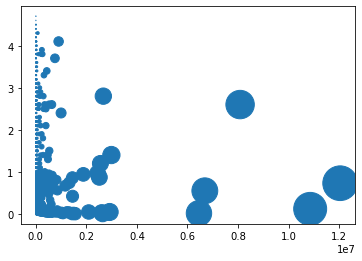

In [366]:
plt.scatter(cdf['Population'],cdf['Elevation'],s=cdf['Population']/10000)

In [367]:
g1= cdf.groupby('AdministrativeDivision')
g= cdf.groupby('Country')

In [368]:
g['Population'].sum()

Country
Bolivia       6480392
Brazil      157831577
Chile        17943835
Colombia     39736325
Ecuador      10688524
Paraguay      4470748
Peru         21902526
Uruguay       3091253
Name: Population, dtype: int64

In [369]:
c1 = cdf[cdf['Elevation'].notna()].copy()
c1['pop_el'] = c1['Population']*c1['Elevation']

In [370]:
g1 = c1.groupby('AdministrativeDivision')

In [371]:
wh = (g1['pop_el'].sum()/g1['Population'].sum())
wh.name = 'weighted_height'
div = wh.to_frame()

In [372]:
div['pop'] = g1['Population'].sum()

In [373]:
from statsmodels.stats.weightstats import DescrStatsW

In [374]:
st = {}
for g,v in g1:
    values = v['Elevation']
    weights = v['Population']
    st[g]=DescrStatsW(values, weights=weights, ddof=1).std
st = pd.Series(st)

In [375]:
div['stw']=st

In [376]:
d1 = div.sort_values('pop',ascending=False)

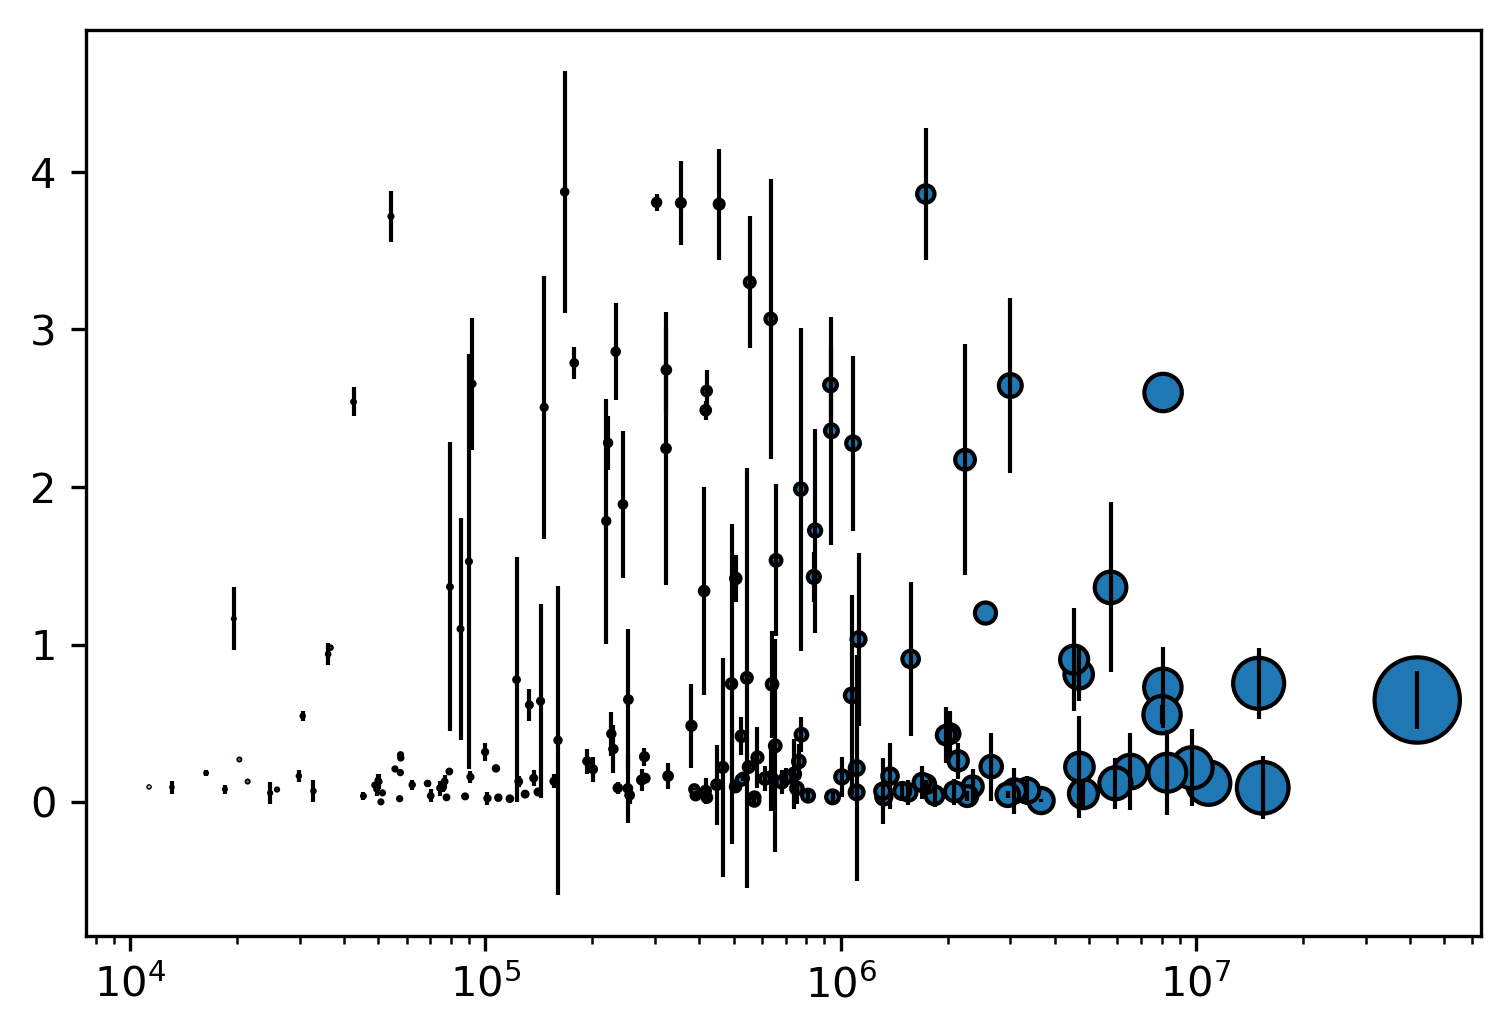

In [377]:
f,ax = plt.subplots(dpi=300)

ax.scatter(d1['pop'],d1['weighted_height'],s=d1['pop']/100000,edgecolors='k')
ax.errorbar(d1['pop'],d1['weighted_height'],yerr=d1['stw'],lw=0,elinewidth=1,zorder=100,c='k')
ax.set_xscale('log')

In [381]:
df['dt']=pd.to_datetime(df['date'])
df1 = df.set_index('dt')

In [382]:
df2=df1.groupby(['adm1_isocode',pd.Grouper(freq='M')]).sum()['deaths'].unstack().T

In [383]:
df3 = df2['2019-01-01':'2019-12-31']

In [384]:
df3.index = df3.index.month

In [385]:
df3.isna().sum().sum()

0

In [386]:
mm = df2['2020-03':'2024']

In [387]:
mm.index = mm.index.month

In [388]:
m2 = mm.sum()/(mm * 0 + df3).sum()

In [389]:
m1 = (mm/df3).mean()

(0.5, 3.0)

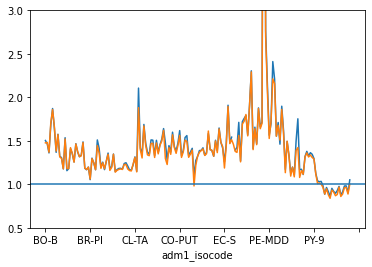

In [390]:
m1.plot()
m2.plot()
ax = plt.gca()
ax.axhline(1)
ax.set_ylim(0.5,3)

In [391]:
adm_dic=pd.read_csv('./data/adm_dic.csv')

In [392]:
m2.name='ratio'
m3 = m2.to_frame()

In [393]:
f1 = pd.merge(m2,adm_dic,left_index=True, right_on='admi',how='inner',
         validate='1:1')

In [394]:
f1

,ratio,mname,pop,country,adm,admi
0,1.477348,"Beni, Bolivia",421196.0,Bolivia,Beni,BO-B
2,1.483096,"Cochabamba, Bolivia",1930143.0,Bolivia,Cochabamba,BO-C
1,1.369958,"Chuquisaca, Bolivia",576153.0,Bolivia,Chuquisaca,BO-H
3,1.705101,"La Paz, Bolivia",2706359.0,Bolivia,La Paz,BO-L
5,1.860465,"Pando, Bolivia",110436.0,Bolivia,Pando,BO-N
...,...,...,...,...,...,...
166,0.888889,"Salto, Uruguay",124878.0,Uruguay,Salto,UY-SA
167,0.962594,"San Jose, Uruguay",108309.0,Uruguay,San Jose,UY-SJ
168,0.964088,"Soriano, Uruguay",82595.0,Uruguay,Soriano,UY-SO
169,0.889441,"Tacuarembo, Uruguay",90053.0,Uruguay,Tacuarembo,UY-TA


In [871]:
f2 = pd.merge(d1.drop('pop',axis=1),f1,left_index=True,
         right_on='mname',validate='1:1')

f2 = f2.sort_values('pop',ascending=False)
f2 = f2[f2['ratio']<3]
bo=f2['country']=='Brazil'
# f2 = f2[bo]

cme = f2.groupby('country').median()

f2 = pd.merge(cme,f2,left_on='country',right_on='country',suffixes=['_r',''])
# f2['ratio']=f2['ratio']/f2['ratio_r']

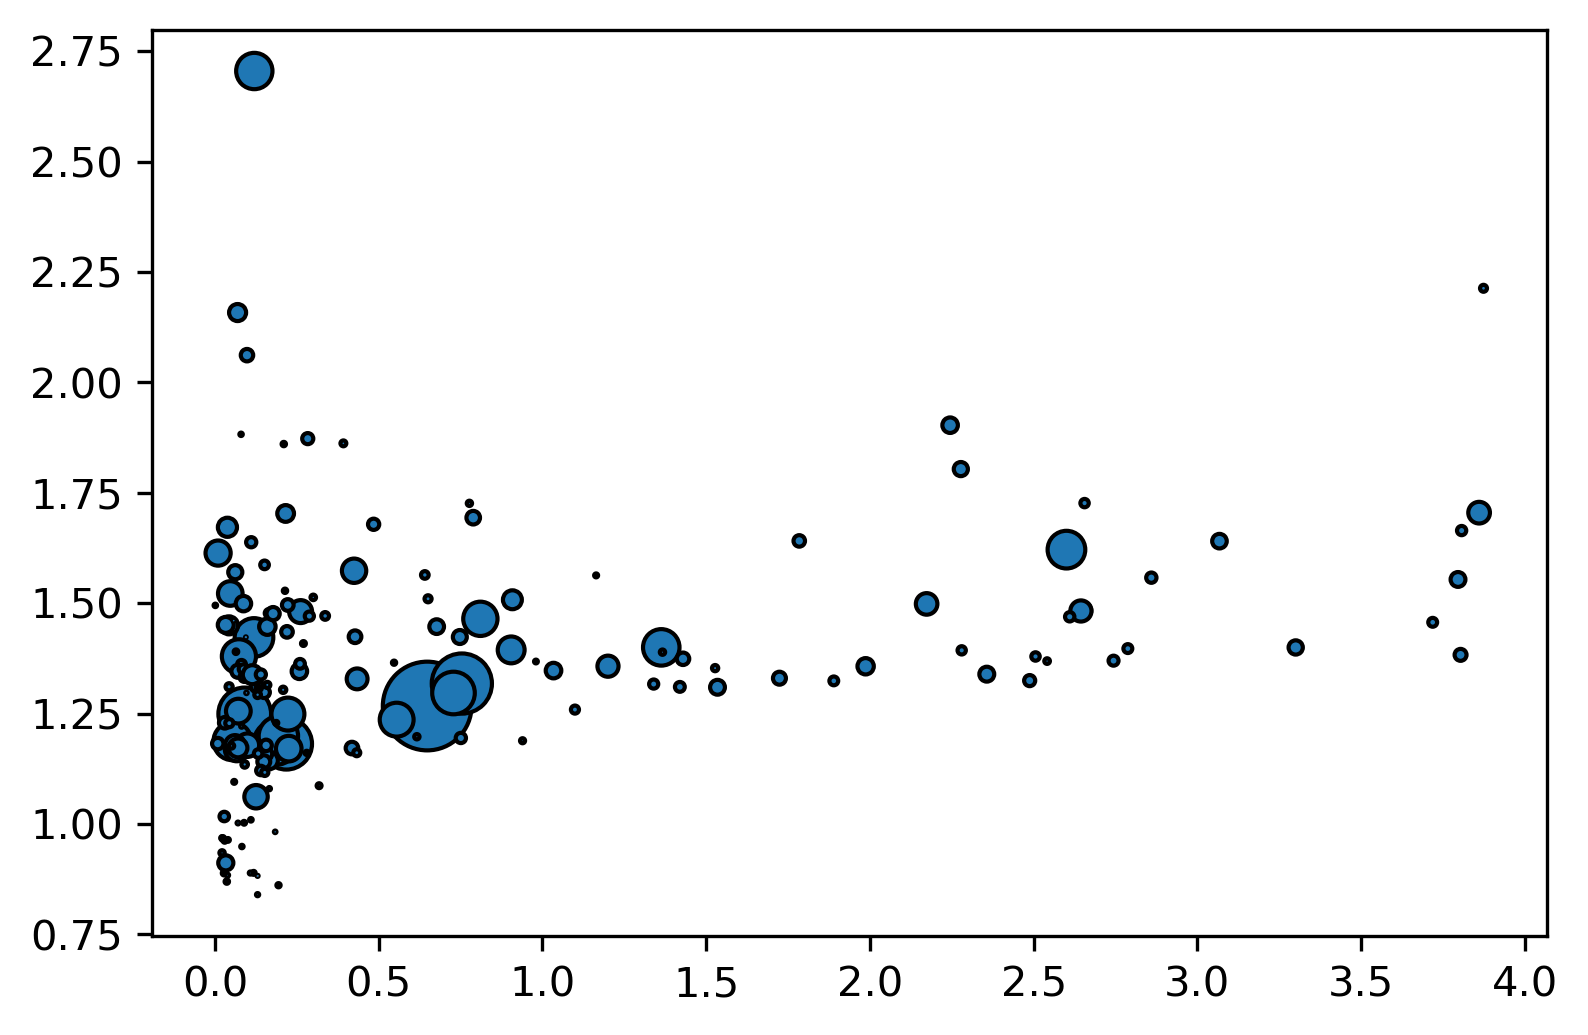

In [874]:
f,ax= plt.subplots(dpi=300)
ax.scatter(
    f2['weighted_height'],
    f2['ratio'],
    s=f2['pop']/100000,
    edgecolors='k'
)
# ax.set_ylim(.5,3)

In [982]:
mea = f2['ratio'].mean()

wmea = (f2['ratio']*f2['pop']).sum()/f2['pop'].sum()

In [876]:
co = f2['country']

In [906]:
dic_ = co.drop_duplicates().reset_index(drop=True).reset_index().set_index('country')['index'].to_dict()

In [907]:
f2['ci']=f2['country'].replace(dic_)

In [908]:
cm = plt.get_cmap('tab10')

In [909]:
cs = [cm(i) for l,i in f2['ci'].items()]

In [910]:
from sklearn.linear_model import QuantileRegressor,LinearRegression

In [911]:
qr = QuantileRegressor(alpha=0)
qr1 = LinearRegression()
qr2 = LinearRegression()

In [912]:
from sklearn.preprocessing import StandardScaler

In [913]:
f2_ = f2.sort_values('weighted_height')
X = f2_[['weighted_height']]
y = f2_[['ratio']]

In [914]:
s1 = StandardScaler()
s2 = StandardScaler()

In [915]:
X1 = s1.fit_transform(X)
y1 = s2.fit_transform(y)

In [916]:
qr.fit(X1,y1[:,0])
qr1.fit(X1,y1[:,0])
qr2.fit(X,y.values[:,0])

LinearRegression()

In [888]:
yp11 = qr.predict(X1)
yp12 = qr1.predict(X1)
yp13 = qr2.predict(X)

In [889]:
yp111 = s2.inverse_transform(yp11.reshape(-1,1))[:,0]
yp112 = s2.inverse_transform(yp12.reshape(-1,1))[:,0]

(0.75, 2.8)

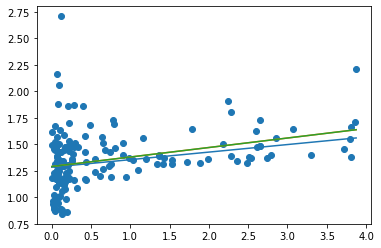

In [890]:
plt.plot(X.values[:,0],yp111)
plt.plot(X.values[:,0],yp112)
plt.plot(X.values[:,0],yp13)
plt.scatter(X.values[:,0],y.values[:,0])
plt.gca().set_ylim(.75,2.8)

In [921]:
means = {}
wmeans_ = {}
fits = {}
f_xy = {}
for c in dic_.keys():
    boo = f2['country']==c
    means[c]=f2[boo]['ratio'].mean()
    _f = f2[boo].sort_values('weighted_height')
    wm = (_f['ratio'] * _f['pop']).sum()/_f['pop'].sum()
    wmeans_[c]=wm
    
    
    lr = QuantileRegressor(alpha=0)
#     lr = LinearRegression()
    _X = _f[['weighted_height']]
    _y = _f['ratio']
    lr.fit(_X,_y)
    fits[c] = lr
    f_xy[c] = [_X.values[:,0],lr.predict(_X)]
    

In [923]:
means = pd.Series(means).sort_values(ascending=False).to_dict()
dic = {}
wmeans = {}
for i,v in means.items():
    dic[i] = dic_[i]
    wmeans[i] = wmeans_[i]
    

<AxesSubplot:>

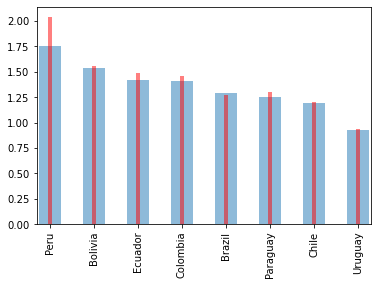

In [924]:
pd.Series(means).plot.bar(alpha=.5)
pd.Series(wmeans).plot.bar(alpha=.5,color='r',width=.1)

{'Peru': 6,
 'Bolivia': 0,
 'Ecuador': 4,
 'Colombia': 3,
 'Brazil': 1,
 'Paraguay': 5,
 'Chile': 2,
 'Uruguay': 7}

In [944]:


doff = {
    'Peru': 0,
     'Bolivia': 0,
     'Ecuador': .01,
     'Colombia': -.01,
     'Brazil': 0,
     'Paraguay': 0,
     'Chile': 0,
     'Uruguay': 0
}

In [1031]:
fy = f' $y = {qr2.coef_[0]:.2f}x + {qr2.intercept_:.2f}$'

In [1032]:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

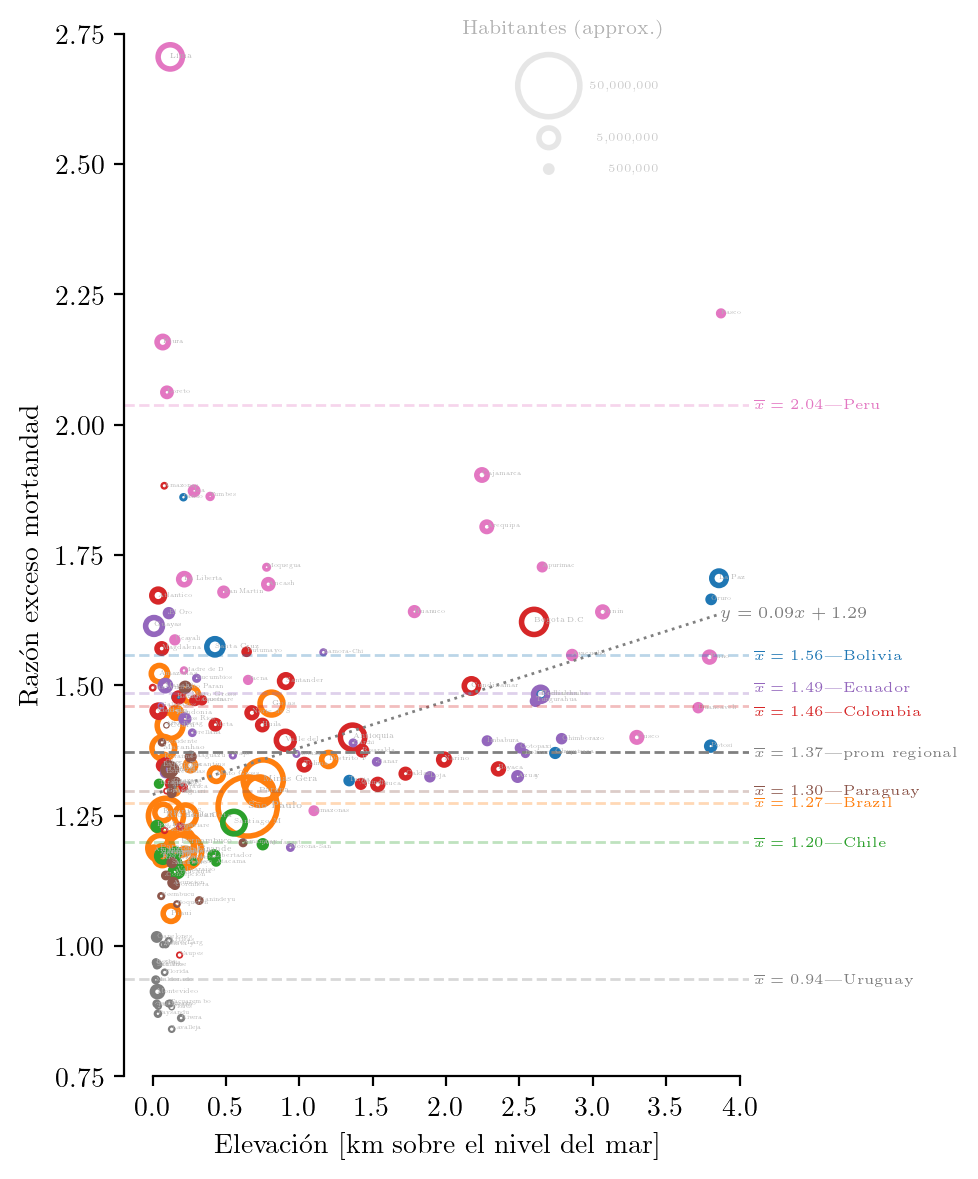

In [1034]:
f,ax= plt.subplots(dpi=200,figsize=(5,6))
ax.scatter(
    f2['weighted_height'],
    f2['ratio'],
    s=f2['pop']/100000,
    edgecolors=cs,
    lw=2,
    facecolor='none'
)
ax.set_ylim(.75,2.75)
ax.axhline(wmea,c='.5',ls='--',lw=1)
ax.plot(X.values[:,0],yp13,ls=':',c='.5',lw=1)
ax.text(X.values[-1,0],yp13[-1],fy,va='center',fontsize=6,c='.5')


sns.despine(f,trim=True)
ax.set_ylabel('Razón exceso mortandad')
ax.set_xlabel('Elevación [km sobre el nivel del mar]')

# al = {0:'bottom',1:'top'}

for i,c in enumerate(dic.keys()):
    ax.axhline(wmeans[c],alpha=.3,lw=1,ls='--',c=cm(dic[c]))
#   ax.plot(*f_xy[c],ls='-.',lw=1,alpha=.5)
#   ax.text(.5,1-i/20,c,transform=ax.transAxes,c=cm(dic[c]))
    ax.text(4.1,wmeans[c]+doff[c],f'$\overline{{x}}={wmeans[c]:.2f}$|{c}',
            fontsize=5,c=cm(dic[c]),va='center')
    pass

ax.text(4.1,wmea,f'$\overline{{x}}={wmea:.2f}$|prom regional',
        fontsize=5,c='.5',va='center')

for i,r in f2.iterrows():
    ax.text(r['weighted_height'],r['ratio'],
           r['adm'][:10], fontsize = (r['pop'])**.5/5000+2,
            c='.7'
           )
xx = [2.7,2.7,2.7]
yy = [2.65,2.55,2.49]
pp = [5e7,5e6,5e5]
ax.scatter(
    xx,
    yy,
    s=np.array(pp)/100000,
    lw=2,
    facecolor='none',
    edgecolor='.9')

for x,y,p in zip(xx,yy,pp):
    ax.text(x+.75,y,f'{int(p):,}',va='center',ha='right',fontsize=4,c='.8')
    
ax.text(xx[0]+.1,2.75,'Habitantes (approx.)',fontsize=7,c='.7',ha='center')
f.tight_layout()
f.savefig('reg_alt.pdf')